<a href="https://colab.research.google.com/github/Pondorasti/DS-2.1/blob/main/Class%20Work/Airbnb_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NYC Airbnb Dataset
In this notebook we will go over the New York City Airbnb Open Dataset, which can be found on [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). This dataset contains information and metrics for Airbnb listings from NYC, NY, 2019. 

The goal of this notebook is to analyze listing prices, relationship between different features, and ultimately try to predict future prices.


---

Import all required libraries 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

Read and convert Airbnb CSV into a DataFrame

In [3]:
airbnb_df = pd.read_csv("https://raw.githubusercontent.com/Pondorasti/DS-2.1/main/Datasets/Airbnb_NYC_2019.csv")

## Explore Data Set

In [4]:
airbnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [5]:
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

Intuitively, we can assume that properties like `neighbourhood` and `room_type` will play a big role in the final price of the listing. Let's try to prove this by creating a scatterplot based on the relationship between `room_type` and `price`. 

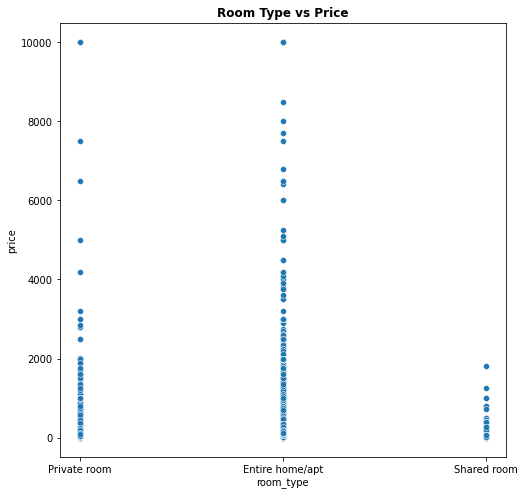

In [6]:
plt.figure(figsize=(8,8))
plt.title("Room Type vs Price", weight='bold')
sns.scatterplot(x="room_type", y="price", data=airbnb_df)

We can see that shared rooms have a way smaller ceiling price which makes sense. We can go even further and visualize the prices in the context of location by settting the hue to `neighbourhood_group`.



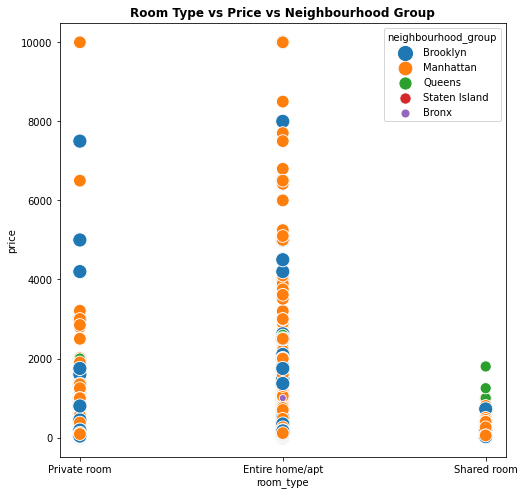

In [7]:
plt.figure(figsize=(8,8))
plt.title("Room Type vs Price vs Neighbourhood Group", weight='bold')
sns.scatterplot(x="room_type", y="price", hue="neighbourhood_group", size="neighbourhood_group", sizes=(50, 200), data=airbnb_df)

`Manhattan` has the highest prices for `Private room` and `Entire home/apt`, but the highest prices for `Shared room` come from `Queens`.

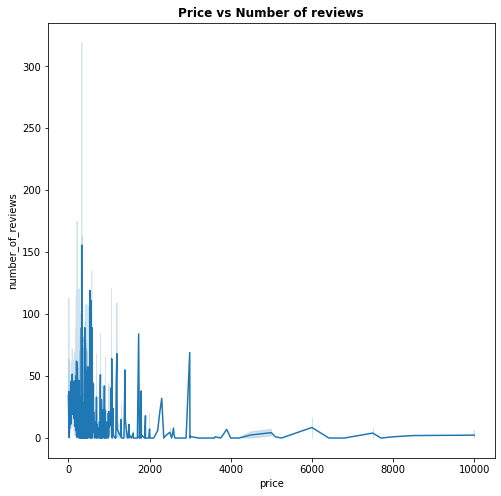

In [8]:
plt.figure(figsize=(8,8))
plt.title("Price vs Number of reviews", weight='bold')
sns.lineplot(x="price", y="number_of_reviews", data=airbnb_df)

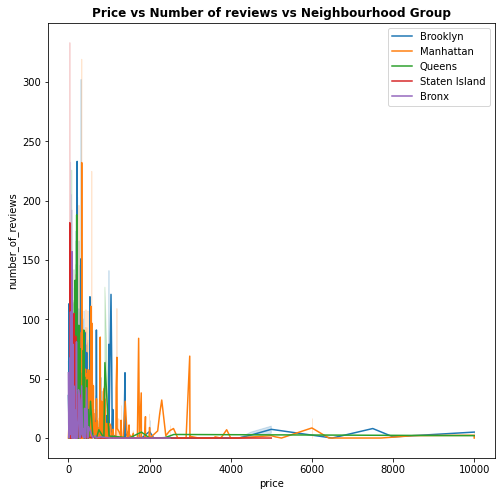

In [9]:
plt.figure(figsize=(8,8))
plt.title("Price vs Number of reviews vs Neighbourhood Group", weight='bold')
sns.lineplot(x="price", y="number_of_reviews", data=airbnb_df[airbnb_df["neighbourhood_group"] == "Brooklyn"], label="Brooklyn")
sns.lineplot(x="price", y="number_of_reviews", data=airbnb_df[airbnb_df["neighbourhood_group"] == "Manhattan"], label="Manhattan")
sns.lineplot(x="price", y="number_of_reviews", data=airbnb_df[airbnb_df["neighbourhood_group"] == "Queens"], label="Queens")
sns.lineplot(x="price", y="number_of_reviews", data=airbnb_df[airbnb_df["neighbourhood_group"] == "Staten Island"], label="Staten Island")
sns.lineplot(x="price", y="number_of_reviews", data=airbnb_df[airbnb_df["neighbourhood_group"] == "Bronx"], label="Bronx")

## Correlation Heatmap

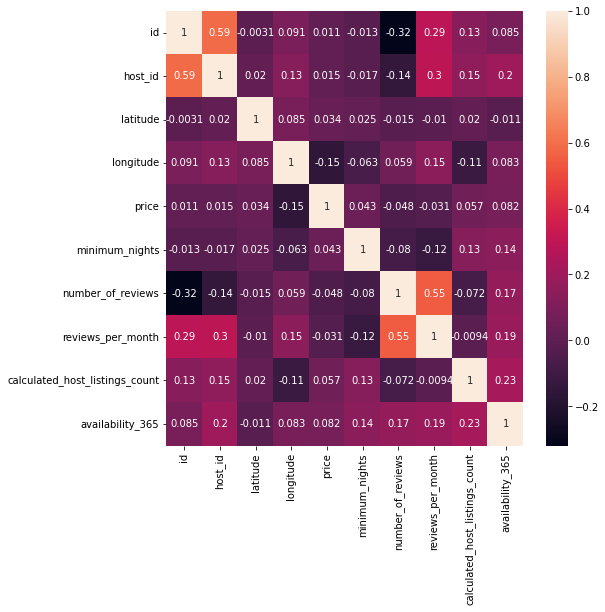

In [10]:
corr = airbnb_df.corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True)

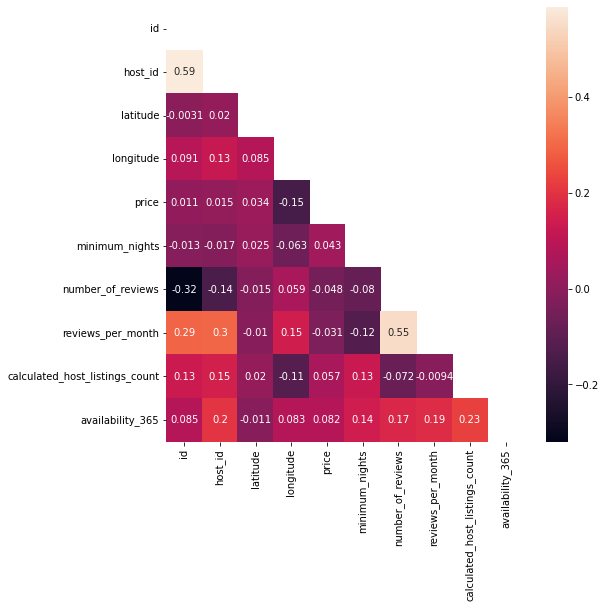

In [11]:
plt.figure(figsize=(8,8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask)

The correlation heatmap tells us that there is no strong relationship between `price` and all the other features. Therefore, there's no need to remove any feature from the data set.

## Data Preprocessing

Before we get started on training the model, we should first prepare the data. I will first remove all the features that are irrelevant and don't hold any significant values.

In [12]:
airbnb_df = airbnb_df.drop(columns=["name", "id", "host_id", "host_name", "last_review"])
airbnb_df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


While checking for null values, we can notice how `reviews_per_month` has some missing values. We will replace those with the mean.

In [13]:
airbnb_df.isnull().sum()

neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [14]:
reviews_mean = airbnb_df["reviews_per_month"].mean()
airbnb_df["reviews_per_month"].fillna(reviews_mean, inplace=True)
airbnb_df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Let's also map the categorial data, `neighbourhood_group`, `neighbourhood`, `room_type`, to 1s and 0s that can be understood by our model.

In [15]:
airbnb_df["neighbourhood_group"] = airbnb_df["neighbourhood_group"].astype("category").cat.codes
airbnb_df["neighbourhood"] = airbnb_df["neighbourhood"].astype("category").cat.codes
airbnb_df["room_type"] = airbnb_df["room_type"].astype("category").cat.codes

airbnb_df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,1,108,40.64749,-73.97237,1,149,1,9,0.210000,6,365
1,2,127,40.75362,-73.98377,0,225,1,45,0.380000,2,355
2,2,94,40.80902,-73.94190,1,150,3,0,1.373221,1,365
3,1,41,40.68514,-73.95976,0,89,1,270,4.640000,1,194
4,2,61,40.79851,-73.94399,0,80,10,9,0.100000,1,0


Final step, normalize data using `StandardScaler`

In [16]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(airbnb_df)

## Train Model

---

Separate features from target and split data into train and test groups

In [17]:
y = airbnb_df["price"]
X = airbnb_df.drop(columns=["price"])

X_train, X_test, y_train, y_test = train_test_split(X, y)

Create Linear Regression model and fit the train data set

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Conclusion

In [19]:
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R2: {r2}\nMSE: {mse}")

R2: 0.11036695292895804
MSE: 40613.192680340624


The result shows that the model is underfitting, having a bad R squared score. I'm not entirely sure why the model performance is not as good as I hoped. One thing that I've noticed is that the price distribution is heavily skewed, which can be seen in the chart bellow. Normalizing the data, might make it easier to interpret and perform statistical analysis. Along the same lines, PCA might be another good option to use in order to reduce the number of features.



Text(0.5, 1.0, 'Price Distribution Plot')

<Figure size 576x576 with 0 Axes>

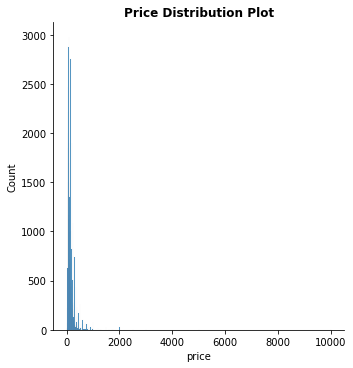

In [21]:
plt.figure(figsize=(8, 8))
sns.displot(airbnb_df['price'])
plt.title("Price Distribution Plot", weight="bold")